# Table of Contents

1. [Import & Set Up](#import_everything)
2. [Load data](#load_data)
3. [Get the parameter that's being adjusted and the values](#Get_the_parameter_thats_being_adjusted_and_the_values)
3. [Plot learning rate vs. within pair correlation (pre- and post-learning)](#Plot_learning_rate_vs_within_pair_correlation_pre_and_post_learning)
4. [Plot time vs. within pair correlation (across learning rates)](#Plot_time_vs_within_pair_correlation_across_learning_rates)

# Import & Set Up
<a id='import_everything'></a>

In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.animation as animation
import os as os
from collections import defaultdict
import shutil
import glob
import sys
from statsmodels.stats.anova import AnovaRM





# Load data
<a id='load_data'></a>

In [2]:
print('Number of arguments:', len(sys.argv), 'arguments.')
print('Argument List:', str(sys.argv))
print('---')
from_cmdLine = sys.argv[-1]
print(from_cmdLine)

print('---')

if from_cmdLine == 'cmd' :
    data_file = sys.argv[-2]
    print('using command line to set data')
    data_dir = data_file + '/'
else :
    print('using script to set data')

#     data_dir = '/Users/victoria/go/src/github.com/emer/leabra/examples/schlichting/data/2021_12_17_schlichting/'
#     data_dir = '/Users/victoria/go/src/github.com/emer/leabra/examples/favila/data/2021_12_17_favila/'
#     data_dir = '/Users/victoria/go/src/github.com/emer/leabra/examples/color_diff/data/2021_12_17_color_diff'
#     data_dir = '/Users/victoria/go/src/github.com/emer/leabra/examples/favila/data/2021_12_17_favila/'
    data_dir = '/Users/victoria/go/src/github.com/emer/leabra/examples/color_diff/data/2022_03_08_lrate_5_6/'
    data_dir = './figs/fig6/'



results_dir = data_dir + '/results/'
if not os.path.exists(results_dir) :
    os.mkdir(results_dir)

Number of arguments: 3 arguments.
Argument List: ['/usr/people/qanguyen/anaconda3/envs/leabra/lib/python3.8/site-packages/ipykernel_launcher.py', '-f', '/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-09035e44-0a1c-4bd1-a6b8-a8f0ea9f8662.json']
---
/mnt/cup/people/qanguyen/.local/share/jupyter/runtime/kernel-09035e44-0a1c-4bd1-a6b8-a8f0ea9f8662.json
---
using script to set data


# Get the parameter that's being adjusted and the values:
<a id='Get_the_parameter_thats_being_adjusted_and_the_values'></a>

In [3]:
def find_parameter_and_value(directory):
    #This function will figure out the parameter and the value based on the directory name. 
    #i.e. results_--HiddNumOverlapUnits=4 will be interpretted as parameter = 'HiddNumOverlapUnits' 
    #and value = 4
    
    head_tail = os.path.split(directory)
    
    last_dir = head_tail[1]
    
    temp = last_dir.split('=')
    
    try:
        value = float(temp[1])
    except:
        value = temp[1]
    
    temp2 = temp[0].split('--')
    parameter = temp2[1]
    
    return parameter, value

In [4]:
# get all files in result dir:

all_corr_list = []

for directory in glob.glob(data_dir + '/results_*'):
    
    #determine the parameter and value for this directory:
    parameter, value = find_parameter_and_value(directory)

    print(parameter, value)
    
    #load in this directory, and make sure there's a column for the parameter being looped:
    temp_df = pd.read_csv(directory + '/fig/results/correlation.csv', index_col = 0)
    temp_df[parameter] = value
    all_corr_list.append(temp_df)

    
#concatenate:
all_corr_df = pd.concat(all_corr_list, 0)
all_corr_df['layer'] = all_corr_df['layer'].astype('category')

all_corr_df
    

    

LRateOverAll 1.0
LRateOverAll 2.0
LRateOverAll 0.0
LRateOverAll 0.5
LRateOverAll 0.02
LRateOverAll 0.01
LRateOverAll 0.1
LRateOverAll 0.05


,|Run,|Epoch,$CurrentTask,$CurrentTest,firstItem,secondItem,correlation,pair,pair_type,layer,overlap,LRateOverAll
0,0,-1,TaskColorWOOsc,TestColorAll,med1,med1,1.000000,med1-med1,identity,hidden,2/6,1.00
1,0,-1,TaskColorWOOsc,TestColorAll,med1,med2,0.242481,med1-med2,med1-med2,hidden,2/6,1.00
2,0,-1,TaskColorWOOsc,TestColorAll,med2,med1,0.242481,med2-med1,redundant,hidden,2/6,1.00
3,0,-1,TaskColorWOOsc,TestColorAll,med2,med2,1.000000,med2-med2,identity,hidden,2/6,1.00
4,0,0,TaskColorRecall,TestColorAll,med1,med1,1.000000,med1-med1,identity,hidden,2/6,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
163,1,18,TaskColorRecall,TestColorAll,med2,med2,1.000000,med2-med2,identity,output,2/6,0.05
164,1,19,TaskColorRecall,TestColorAll,med1,med1,1.000000,med1-med1,identity,output,2/6,0.05
165,1,19,TaskColorRecall,TestColorAll,med1,med2,1.000000,med1-med2,med1-med2,output,2/6,0.05
166,1,19,TaskColorRecall,TestColorAll,med2,med1,1.000000,med2-med1,redundant,output,2/6,0.05


In [5]:
def select_data(data):
    
    is_within_pair = data['pair_type'] == 'med1-med2'
    is_layer = data['layer'] == 'hidden'
    is_pre_or_post = data['|Epoch'].isin([data['|Epoch'].min(), data['|Epoch'].max()])

    within_pair_correlation_pre_post = data[(is_within_pair) & (is_layer) & (is_pre_or_post)]
    within_pair_correlation_pre_post
    
    return within_pair_correlation_pre_post

within_pair_correlation_pre_post = select_data(all_corr_df)




# Plot learning rate vs. within pair correlation (pre- and post-learning)
<a id='Plot_learning_rate_vs_within_pair_correlation_pre_and_post_learning'></a>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


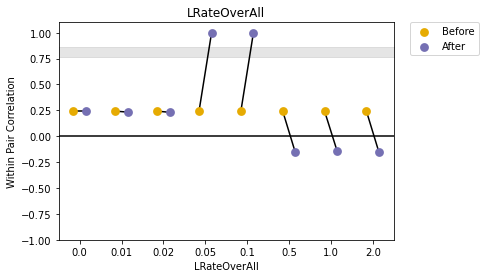

In [9]:
def pre_post_corr_parameter_shift(data, x_parameter, ribbon = False):

#     ax = sns.stripplot(x = parameter, y = 'correlation', hue = '|Epoch', 
#                  data = within_pair_correlation_pre_post, dodge = .3, alpha = .1, palette = 'Dark2_r')

    ax = sns.pointplot(x = parameter, y = 'correlation', hue = '|Epoch', 
                  linestyles = '', dodge = .3, data = data, palette = 'Dark2_r')
    
    num_categories = len(data[parameter].unique())
    for (x1, y1), (x2, y2) in zip(ax.lines[0].get_xydata(), ax.lines[num_categories + 1].get_xydata()):
        ax.plot([x1, x2], [y1, y2], color='black', zorder = 0)

    plt.axhline(0, color = 'k', linestyle = '-', zorder = 0)

    handles, labels = ax.get_legend_handles_labels()
    
    l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    
    x = np.arange(-1, 8, .1)
    slope = 0
    y1 = x*slope +.77
    y2= x*slope +.86
    
    if ribbon == True:
        plt.fill_between(x, y1, y2, alpha = .2, color = 'grey', zorder = 0)
        
        
        
        
    l.get_texts()[0].set_text('Before')
    l.get_texts()[1].set_text('After')
    title = parameter
    plt.ylim([-1,1.1])
    plt.xlim(-.5,7.5)

    
    plt.ylabel('Within Pair Correlation')
    plt.title(title)
    plt.savefig(results_dir + title + '.png', bbox_inches='tight')
    plt.savefig(results_dir + title + '.eps', bbox_inches='tight')

    plt.show()
    
    return ax
ax = pre_post_corr_parameter_shift(within_pair_correlation_pre_post, 'overlap', ribbon = True)

# Plot time vs. within pair correlation (across learning rates)
<a id='Plot_time_vs_within_pair_correlation_across_learning_rates'></a>

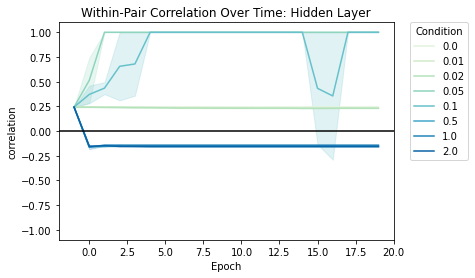

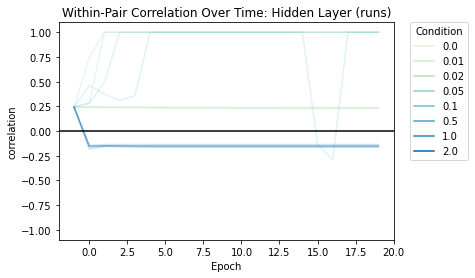

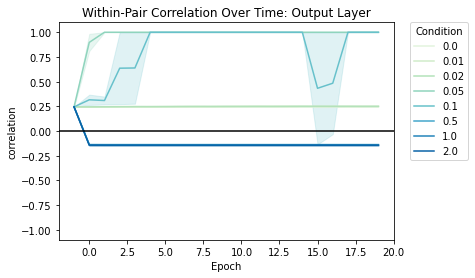

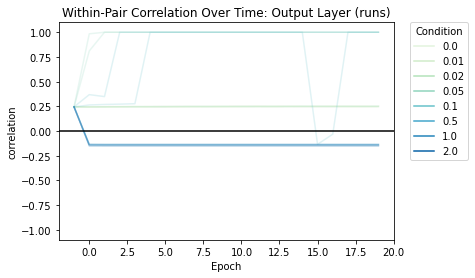

In [7]:



def plot_within_pair_correlation(data, layer, split = False):
    plt.clf()
    is_within_pair = data['pair_type'] == 'med1-med2'
    is_layer = data['layer'] == layer

    within_pair_correlation_pre_post = data[(is_within_pair) & (is_layer)]
    
    # print("range len", range(len(within_pair_correlation_pre_post)))
    within_pair_correlation_pre_post = (within_pair_correlation_pre_post.set_index(pd.Series((range(len(within_pair_correlation_pre_post))))))
    within_pair_correlation_pre_post[parameter] = within_pair_correlation_pre_post[parameter].astype('category')

    # display(within_pair_correlation_pre_post[parameter])
    if split == True:
        sns.lineplot(x = '|Epoch', y = 'correlation', hue=parameter, data = within_pair_correlation_pre_post,
                     palette = 'GnBu', units = '|Run', estimator = None, alpha = .2)
    elif split == False:
        sns.lineplot(x = '|Epoch', y = 'correlation', hue=parameter, data = within_pair_correlation_pre_post,
                     palette = 'GnBu')

    plt.axhline(y = 0, c = 'k')
    plt.ylim([-1.1, 1.1])
    # plt.xlim([-2, 3])
    title = 'Within-Pair Correlation Over Time: ' + layer.capitalize() + ' Layer'
    if split == True:
        title = title + ' (runs)'
    plt.legend(title = 'Condition', bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad=0.)
    plt.xlabel('Epoch')
    plt.title(title)
        
    plt.savefig(results_dir + title + '.png', bbox_inches='tight')
    plt.show()

    
plot_within_pair_correlation(all_corr_df, 'hidden', split = False)
plot_within_pair_correlation(all_corr_df, 'hidden', split = True)
plot_within_pair_correlation(all_corr_df, 'output', split = False)
plot_within_pair_correlation(all_corr_df, 'output', split = True)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

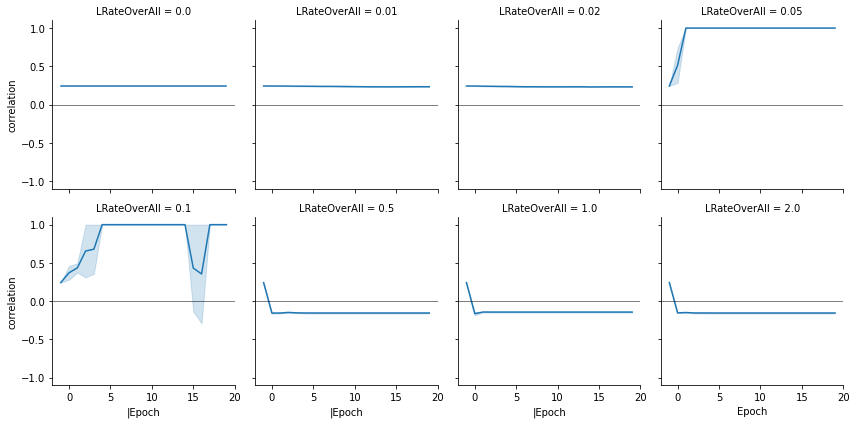

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

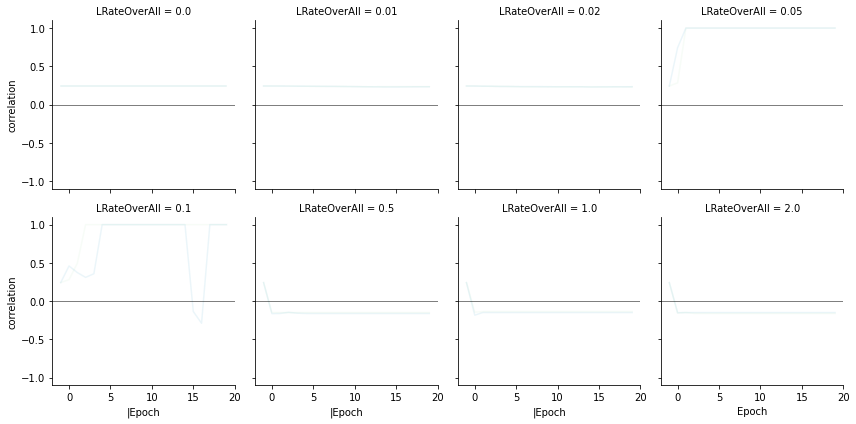

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

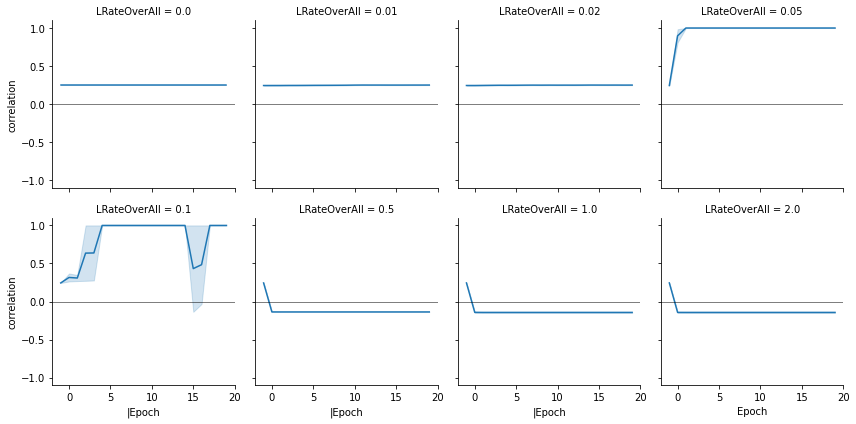

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

<Figure size 432x288 with 0 Axes>

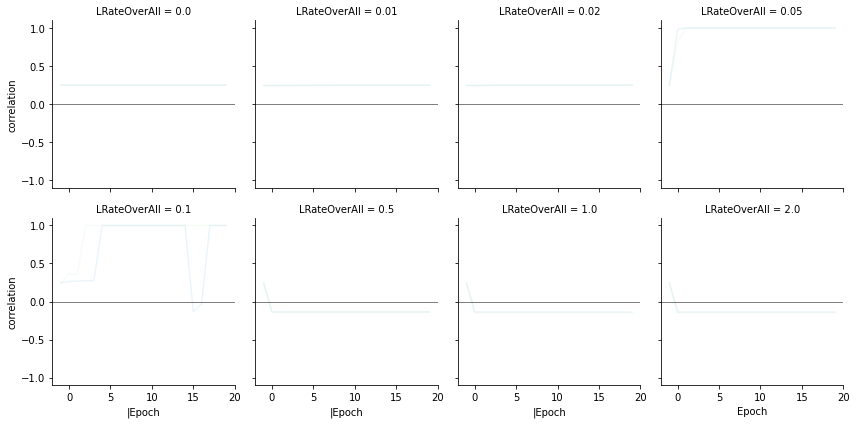

In [8]:



def plot_within_pair_correlation_facet(data, layer, split = False):
    plt.clf()
    is_within_pair = data['pair_type'] == 'med1-med2'
    is_layer = data['layer'] == layer

    within_pair_correlation_pre_post = data[(is_within_pair) & (is_layer)]
    
    # print("range len", range(len(within_pair_correlation_pre_post)))
    within_pair_correlation_pre_post = (within_pair_correlation_pre_post.set_index(pd.Series((range(len(within_pair_correlation_pre_post))))))
    within_pair_correlation_pre_post[parameter] = within_pair_correlation_pre_post[parameter].astype('category')

    # display(within_pair_correlation_pre_post[parameter])

    if split == False:
        g = sns.FacetGrid(within_pair_correlation_pre_post, col=parameter, col_wrap=4)
        g.map(sns.lineplot,'|Epoch', 'correlation',
                         palette = 'GnBu')
        g.map(plt.axhline, y=0, linewidth = .5, c="k")


    elif split == True:
        g = sns.FacetGrid(within_pair_correlation_pre_post, col=parameter, col_wrap=4)
        g.map(sns.lineplot, '|Epoch', 'correlation' , '|Run', 
                     palette = 'GnBu', alpha = .1)
        
        g.map(plt.axhline, y=0, linewidth = .5, c="k")

    plt.ylim([-1.1, 1.1])

        

    # plt.ylim([-1.1, 1.1])
    # plt.xlim([-2, 3])
    title = 'Fig 6B: Within-Pair Correlation Over Time: ' + layer.capitalize() + ' Facet Layer'
    if split == True:
        title = title + ' (runs)'
    plt.xlabel('Epoch')
#     plt.title(title)
        
    plt.savefig(results_dir + title + '.png', bbox_inches='tight')
    plt.savefig(results_dir + title + '.eps', bbox_inches='tight')

    plt.show()
    

    
plot_within_pair_correlation_facet(all_corr_df, 'hidden', split = False)
plot_within_pair_correlation_facet(all_corr_df, 'hidden', split = True)

plot_within_pair_correlation_facet(all_corr_df, 'output', split = False)
plot_within_pair_correlation_facet(all_corr_df, 'output', split = True)



